# CLUSTER-DATA-SPLIT

### Reference
This tool implements the methods described in the paper following paper.

> Hanna Wecker, Annemarie Friedrich, and Heike Adel.
*ClusterDataSplit: Evaluation Challenging Data Splits for Model Performance Evaluation*. In Proceedings of Eval4NLP 2020.

If you use this tool, please cite the above paper.


### LICENSE info
ClusterDataSplit is open-sourced under the AGPL-3.0 license. See the LICENSE file at the top level of this project for details. For a list of other open source components included in ClusterDataSplit, see the file 3rd-party-licenses.txt at the top level of this project.

# (2) Creating Strategic Data Splits

This notebook creates different data splits for training and evaluation of NLP models. 

To obtain **strategic** data splits, different steps have to be conducted. First of all, the text input data needs to be transformed into a vector representation. Per default, the framework presented in this notebook uses a pre-trained Word2Vec model to generate the vector representations. Then, the dimensionalities of vectors are reduced with principal component analysis before (modified) K-Means algorithms serve for clustering the data.

The notebook can also be used for creating **randomized** data splits. 

## Conda environment
To ensure that all packages can be loaded, run this notebook in the environment specified by the file `clusterdatasplit.yml`.

In [1]:
# load packages
import sklearn
print(sklearn.__version__)
version_nr = int(sklearn.__version__.split(".")[1])
if version_nr > 23:
    print("Careful - ClusterDataSplit only works with sklearn <= version 0.23 !!")

import matplotlib
import seaborn as sns
import pickle as pkl
import pandas as pd
import numpy as np
import os
from gensim.models import KeyedVectors, Word2Vec
from utils import *
from sklearn.preprocessing import StandardScaler

0.23.1


In [2]:
# Options for Figures
sns.set(style = 'whitegrid', font = 'sans-serif', font_scale=2)
sns.set_palette("hls", 5)
matplotlib.rcParams['figure.figsize'] = (10, 7.5)

## Set the data path and load input data

In [37]:
# Path to folder with all files related to the dataset in question
# project_path = os.path.join(os.getcwd(), "data/toy_data") # our toy data binary classification task
project_path = os.path.join(os.getcwd(), "data/patent_classification") # multi-class patent classification

In this folder, you should have:
* a file called `input_data.tsv` containing the columns: `id` (an integer identifier of the instance), `label` (usually a string identifier of the true class) and `text_input_data` (the tokenized text, already processed, e.g., stopwords and punctuation are removed, lemmatization has been performed if necessary, ...)

In [38]:
# Okay, let's load the data.
input_data = pd.read_csv(os.path.join(project_path, "input_data.tsv"), delimiter = "\t")
gold_labels = np.array([input_data['labels']])
text_data = list(input_data['text_input_data'])

### Strategic Data Split Options

* **sentence embeddings**: Per default, sentence vectors are created by averaging word embeddings from a Word2Vec model. If you would like to input your own, customized embeddings, change the value to "customized". Customized word embeddings have to be handed over in the form of a dictionary, where the key is the example ID and the value is the embedding in the form of a (one-dimensional) numpy array. 

* **n_components**: We use a principal component analysis to reduce the dimensionality of the sentence vectors before applying K-Means based algorithms. We recommend to reduce the dimensionality to 5.
    
   
* **clustering_algorithms**: Per default, we suggest using the Size and Distribution Sensitive (SDS) K-Means Algorithm for producing strategic data splits. This algorithm is executed if the option `distribution_sensitive_kmeans` is specified. Alternatively, the user can specify `kmeans` for the regular K-Means Algorithm or `same_size_kmeans` for the same size K-Means algorithm introduced by Schubert and Zimek. Randomized baseline splits can be generated by selecting `randomized`.
        
* **num_clusters**: The number of clusters in which the data should be divided.
   
* **n_jobs**: Only applicable for the Size and Distribution Sensitive K-Means algorithm. The calculation of the clusters can be conducted in parallel. If you wish to execute in parallel, the number of workers can be specified here.
   
* **max_ids_labels**: Only applicable for the Size and Distribution Sensitive K-Means algorithm. It is very important to hand over the maximum number of IDS for each label and each cluster.  Example: there are two labels in the data, 6 examples carry label 1, 15 examples carry label two. Then, in order to gain clusters with same size and label distribution, the max_ids_labels have to be set as follows: `[np.array([2,2,2]), np.array([5,5,5])]`. This means that for each of the three clusters, 2 examples with label 1 and 5 examples with label 2 can enter the cluster. The clustering algorithm requires the sum of examples assigned to the cluster for the different labels exactly matches the number of examples exisitng in the data for the respective label. Example: if there are 7 examples with label 1 in the data, but we assign the maximum numbers `[2,2,2]` for the respective labels to the clusters, the algorithm will not run and produce an error.

In [39]:
# Sentence Embeddings: "Word2Vec" or "customized"
sentence_embeddings = "Word2Vec"

# Number of Dimensions for PCA
n_components = 5

# Clustering Algorithm and Number of Clusters
# options: 'distribution_sensitive_kmeans', 'same_size_kmeans', 'kmeans', 'randomized'
clustering_algorithm = 'distribution_sensitive_kmeans'
num_clusters = 5

# Options for the Size and Distribution Sensitive K-Means algorithm
n_jobs = 8
print("Number of instances to be clustered:", len(text_data))
max_ids_labels = generate_default_label_distribution(gold_labels, num_clusters)

Number of instances to be clustered: 6458


In [40]:
check_options(sentence_embeddings, clustering_algorithm)

### Load Word Embeddings

Here, either sentence embeddings are created (based on the pre-trained Google News Vectors Word2Vec model) or the customized sentence embeddings are loaded. Here, we simply create **sentence embeddings** by averaging the Word2Vec embeddings for the tokens of the sentence. You can also load your own pre-defined sentence embeddings instead (given as one vector per instance, see Notebook (1)).

If the pretrained Word2Vec model should be used, it is expected to be placed in a folder models within the storage location of the notebook. If customized Word Embeddings should be applied, those are expected to be located directly within the folder holding this notebook.

For example, we are using Google's pretrained Word2Vec model which you can obtain [here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing).

The following code generates sentence embeddings - may take a few minutes depending on the size of your dataset!

In [41]:
if sentence_embeddings == "Word2Vec":
    model_path = os.path.join(os.getcwd(), 'models/GoogleNews-vectors-negative300.bin')
    model = KeyedVectors.load_word2vec_format(model_path, binary = True)
    sentence_vectors_dict, exceptions = create_sentence_vectors(text_data, model)
elif sentence_embeddings == "customized":
    # TODO adapt this here, at least the path!
    sentence_pickle = open(os.path.join(os.getcwd(), '/sentence_dict.pickle'), 'rb')
    sentence_vectors_dict = pkl.load(sentence_pickle)
    sentence_pickle.close()
print("Done loading embeddings, sentence vectors created.")

Done loading embeddings, sentence vectors created.


### Dimensionality Reduction

Before the dimensionality reduction by principal component analysis is performed, the sentence embeddings are centered and scaled. 

In [42]:
# step (1): centering and scaling
sentence_vectors = np.array(list(sentence_vectors_dict.values()))
scaler = StandardScaler().fit(sentence_vectors)
sentence_vectors = scaler.transform(sentence_vectors)

# step (2): perform PCA
sentence_vectors, explained_variance_ratio, explained_variance = perform_pca(sentence_vectors, n_components)

### Clustering

The clustering is performed according to the strategic data splits options: the clustering algorithm is defined above! If you want to compare different data splitting techniques, you have to run this notebook several times with different parameters.

In [43]:
if clustering_algorithm == "kmeans":
    labels_clustering, centroids = perform_kmeans(sentence_vectors, num_clusters)

elif clustering_algorithm == "same_size_kmeans":
    labels_clustering, centroids = perform_kmeans_size(sentence_vectors, num_clusters, n_jobs, max_ids_labels = max_ids_labels)

elif clustering_algorithm == "distribution_sensitive_kmeans":
    labels_clustering, centroids = perform_kmeans_size_distribution(sentence_vectors, num_clusters, gold_labels, n_jobs, max_ids_labels = max_ids_labels)
    
elif clustering_algorithm == "randomized":
    labels_clustering = create_random_datasplits(sentence_vectors, num_clusters)

# add 1, otherwise cluster labels would start at 0 (design choice)
labels_clustering += 1

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   15.6s remaining:   46.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   24.6s finished


### Clustering Output
Let's look at the clusters. Note that in the below plot, colors indicate clusters, not classes/labels.

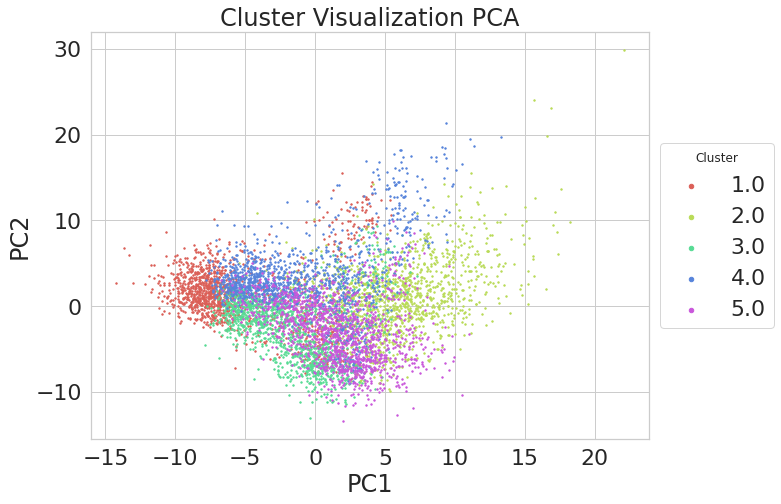

In [44]:
plot_clustering_output(n_components, sentence_vectors, labels_clustering, point_size = 2)

### Save Output Files

The files "clustering_output" and "analysis_input" are stored in the "path" directory. The file "clustering_output" contains an id for each example and the clustering label assigned. The file "analysis_input" includes id, cluster label, gold label and the 2-dimensional vectors representing each example.

In [45]:
save_output_files(labels_clustering, n_components, gold_labels, sentence_vectors, clustering_algorithm, path = project_path)